# Experiment : Dry Bean Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,RidgeCV
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
import seaborn as sns

import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

df=pd.read_excel('Dry_Bean_Dataset.xlsx')
#df['Class']=df['Class'].map({'SEKER':0, 'BARBUNYA':1, 'BOMBAY':2, 'CALI':3, 'DERMASON':4, 'HOROZ':5, 'SIRA':6})
y=df['Class']
del df['Class']
x=preprocessing.StandardScaler().fit(df).transform(df) #normalize
x=pd.DataFrame(x)
data=pd.concat([y,x],axis=1)
train,test=train_test_split(data,test_size=0.3, random_state=1)

train_y = train['Class']
test_y = test['Class'] #response:class
train_x = train
test_x = test
del train_x['Class']
del test_x['Class']
train_x.reset_index(drop=True, inplace=True) 
test_x.reset_index(drop=True, inplace=True) 
train_y.reset_index(drop=True, inplace=True) 
test_y.reset_index(drop=True, inplace=True) 

train_y=pd.get_dummies(train_y)
test_y=pd.get_dummies(test_y)

train_x ##display the data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.994806,1.049952,1.132756,1.113984,0.283600,0.493653,0.985423,1.191139,0.012881,0.463548,0.202877,-0.394635,-1.320305,-0.979735,-0.426032,-0.184032
1,-0.893472,-1.201639,-1.248561,-0.924383,-1.041357,-1.021192,-0.893711,-1.152038,1.186068,0.309620,1.190484,1.094768,1.219271,1.773093,1.099403,0.670733
2,-0.765245,-0.989671,-0.959506,-0.850840,-0.537528,-0.287644,-0.766116,-0.940423,-0.422865,0.339860,0.948061,0.484294,1.072110,0.934467,0.453518,0.844590
3,0.177257,0.498323,0.889111,-0.297491,2.087545,1.393751,0.169068,0.325495,-2.468408,0.729945,-1.385822,-1.827012,0.213500,-1.309621,-1.732060,-1.019966
4,-0.180653,0.056774,0.351344,-0.626872,1.738129,1.270058,-0.181643,-0.109688,0.668518,0.056672,-1.274076,-1.553507,0.683797,-1.014670,-1.494874,0.479673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9522,-0.490921,-0.659489,-0.816262,-0.117820,-1.269053,-1.459721,-0.496953,-0.527601,0.459826,1.002486,1.337334,1.406822,-0.080452,1.262138,1.440633,0.818725
9523,1.031228,1.187607,1.315594,0.979550,0.705948,0.776341,1.012090,1.226536,0.212023,1.186036,-0.394288,-0.771065,-1.211218,-1.156575,-0.784549,-0.118661
9524,-0.676168,-0.851274,-0.825466,-0.719934,-0.467218,-0.204344,-0.678489,-0.800993,0.231821,0.547060,0.819549,0.401137,0.836821,0.713937,0.367758,0.725020
9525,-0.626548,-0.872027,-1.093397,-0.157375,-1.715355,-2.651752,-0.630964,-0.725699,0.574001,0.881892,1.713951,2.074795,-0.029458,2.131909,2.196242,0.870047


In [2]:
train_y

,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...
9522,0,0,0,0,0,1,0
9523,0,0,1,0,0,0,0
9524,0,0,0,1,0,0,0
9525,0,0,0,0,0,1,0


In [3]:
nntrain_x = torch.from_numpy(train_x.to_numpy()).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float()) 
nntest_x= torch.from_numpy(test_x.to_numpy()).float()
nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len

## 1. DNN

In [4]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 7)
        self.softmax = nn.Softmax(dim=1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return  self.softmax(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=5e-3,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
dnn_trainloss=[]
dnn_testloss=[]
t0=time.time()
for epoch in range(300): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)
    
        test_loss = criterion(y_test_pred,y)
    if epoch % 10 == 0:         
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    dnn_trainloss.append(float(train_loss))
    dnn_testloss.append(float(test_loss))
            
dnn_fit = time.time() - t0
print("DNN complexity and model fitted in %.3f s" % dnn_fit)

Net(
  (fc1): Linear(in_features=16, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=7, bias=True)
  (softmax): Softmax(dim=1)
)
epoch 0
            Train set - loss: 1.940377116203308
            Test  set - loss: 1.9426106214523315
            
epoch 10
            Train set - loss: 1.8549273014068604
            Test  set - loss: 1.8903822898864746
            
epoch 20
            Train set - loss: 1.7396055459976196
            Test  set - loss: 1.837659239768982
            
epoch 30
            Train set - loss: 1.8424726724624634
            Test  set - loss: 1.81301748752594
            
epoch 40
            Train set - loss: 1.8131791353225708
            Test  set - loss: 1.8008390665054321
            
epoch 50
            Train set - loss: 1.7832868099212646
            Test  set - loss: 1.793141484260559
            
epoch 60
            Train set - loss: 1.7296770811080933
            Test

In [5]:
#predict
accu=0
for i in range(len(test_x)):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        if np.array(pred).reshape(-1).argmax()==test_y[i:i+1].to_numpy().argmax():
            accu=accu+1
print(accu/len(test_x))

0.8317825661116552


## 2. Resnet

In [6]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(infeatures,outfeatures)
    
    def forward(self, x):
        y = self.fc1(x)
        y= F.relu(y)
        x = self.fc2(x)
        return F.relu(x+y)


class ResNet(nn.Module): 
    def __init__(self):
        super(ResNet, self).__init__()
        self.rblock1 = ResidualBlock(16,32)
        self.rblock2 = ResidualBlock(32,8)
        self.fc3 = nn.Linear(8,7)
        self.softmax = nn.Softmax(dim=1)
 
    def forward(self, x):
        x = self.rblock1(x)
        x = self.rblock2(x)
        x = self.fc3(x)
        return self.softmax(x)
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResNet()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.CrossEntropyLoss() 
optimizer=optim.SGD(net.parameters(),lr=5e-3,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
res_trainloss=[]
res_testloss=[]
t0=time.time()
for epoch in range(300): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()

    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)
    
        test_loss = criterion(y_test_pred,y)
    if epoch % 10 == 0:         
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    res_trainloss.append(float(train_loss))
    res_testloss.append(float(test_loss))
            
dnn_fit = time.time() - t0
print("ResNet complexity and model fitted in %.3f s" % dnn_fit)

ResNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=16, out_features=32, bias=True)
    (fc2): Linear(in_features=16, out_features=32, bias=True)
  )
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=32, out_features=8, bias=True)
    (fc2): Linear(in_features=32, out_features=8, bias=True)
  )
  (fc3): Linear(in_features=8, out_features=7, bias=True)
  (softmax): Softmax(dim=1)
)
epoch 0
            Train set - loss: 1.9476428031921387
            Test  set - loss: 1.9300622940063477
            
epoch 10
            Train set - loss: 1.8151674270629883
            Test  set - loss: 1.8630517721176147
            
epoch 20
            Train set - loss: 1.8105401992797852
            Test  set - loss: 1.8212720155715942
            
epoch 30
            Train set - loss: 1.5818480253219604
            Test  set - loss: 1.594079852104187
            
epoch 40
            Train set - loss: 1.5407465696334839
            Test  set - loss: 1.4861832857131958
         

In [7]:
#predict
accu=0
for i in range(len(test_x)):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        if np.array(pred).reshape(-1).argmax()==test_y[i:i+1].to_numpy().argmax():
            accu=accu+1
print(accu/len(test_x))

0.9111165523996082


## Random Feature

definition of random feature

In [8]:
def sample_1d(pdf, gamma):
    if pdf=='G':
        w=torch.randn(1)*gamma
        return w
    elif pdf=='L':
        w=torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    elif pdf=='C':
        w=torch.distributions.cauchy.Cauchy(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    
def sample(pdf, gamma, d):
    return torch.tensor([sample_1d(pdf, gamma) for _ in range(d)])

class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : shape (D,d)
    b : shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = torch.rand(self.D)*2*torch.pi
        self.W = sample(self.kernel, self.gamma, self.d*self.D).reshape(self.D,self.d)

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : (shape=(n,d))
            to transform; must be single dimension vector
        Returns
        -------
        x : (shape=(n,D))
            Feature space transformation of x
        """
        #print(self.W.shape,self.b.reshape(-1,1).shape,x.shape)
        #print((self.W @ x.T).shape)
       
        result=torch.sqrt(torch.tensor([2.0/self.D])) * torch.cos( self.W @ x.T  + (self.b.reshape(-1,1) @ torch.ones(len(x)).reshape(1,-1))) 
        #print(result.T.shape)
        return result.T

# one

In [9]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=1000, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=1000, shuffle=False)

rff1=RandomFourierFeature(16,100,kernel='G',gamma=0.1)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(100, 7)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        return self.softmax(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.CrossEntropyLoss() 
optimizer=optim.SGD(net.parameters(),lr=1,momentum=0.9) #optim.Adam(...)

loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]
t0 = time.time()
for epoch in range(300): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)
    
        test_loss = criterion(y_test_pred,y)
    if epoch % 10 == 0:         
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    kernelnn_trainloss.append(float(train_loss))
    kernelnn_testloss.append(float(test_loss))
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=100, out_features=7, bias=True)
  (softmax): Softmax(dim=1)
)
epoch 0
            Train set - loss: 1.9002560377120972
            Test  set - loss: 1.8838396072387695
            
epoch 10
            Train set - loss: 1.6718173027038574
            Test  set - loss: 1.6250680685043335
            
epoch 20
            Train set - loss: 1.5207524299621582
            Test  set - loss: 1.4983153343200684
            
epoch 30
            Train set - loss: 1.4509780406951904
            Test  set - loss: 1.4534034729003906
            
epoch 40
            Train set - loss: 1.4299471378326416
            Test  set - loss: 1.4291901588439941
            
epoch 50
            Train set - loss: 1.3821213245391846
            Test  set - loss: 1.4136970043182373
            
epoch 60
            Train set - loss: 1.425174355506897
            Test  set - loss: 1.40309476852417
            
epoch 70
            Train set - loss: 1.402200698852539
      

## 3. multilayer learning

In [24]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff1=RandomFourierFeature(16,32,kernel='C',gamma=0.1)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=1)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(32, 8)
        self.fc2 = nn.Linear(8, 7)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        x = self.fc2(x)
        return self.softmax(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.CrossEntropyLoss() 
optimizer=optim.SGD(net.parameters(),lr=5e-3,momentum=0.9) #optim.Adam(...)

loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]
t0 = time.time()
for epoch in range(300): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)
    
        test_loss = criterion(y_test_pred,y)
    if epoch % 10 == 0:         
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    kernelnn_trainloss.append(float(train_loss))
    kernelnn_testloss.append(float(test_loss))
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=32, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=7, bias=True)
  (softmax): Softmax(dim=1)
)
epoch 0
            Train set - loss: 1.9364911317825317
            Test  set - loss: 1.940797209739685
            
epoch 10
            Train set - loss: 1.7591794729232788
            Test  set - loss: 1.7809686660766602
            
epoch 20
            Train set - loss: 1.6581990718841553
            Test  set - loss: 1.6509960889816284
            
epoch 30
            Train set - loss: 1.7931838035583496
            Test  set - loss: 1.538912296295166
            
epoch 40
            Train set - loss: 1.5251654386520386
            Test  set - loss: 1.4852200746536255
            
epoch 50
            Train set - loss: 1.3683760166168213
            Test  set - loss: 1.4253835678100586
            
epoch 60
            Train set - loss: 1.2581347227096558
            Test  set - loss: 1.4011728763580322
            
epoch

In [25]:
#predict
accu=0
for i in range(len(test_x)):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        if np.array(pred).reshape(-1).argmax()==test_y[i:i+1].to_numpy().argmax():
            accu=accu+1
print(accu/len(test_x))

0.8021547502448579


## 4. Residual multilayer learning

In [26]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff0=RandomFourierFeature(16,32,kernel='C',gamma=0.05)
rff1=RandomFourierFeature(8,8,kernel='G',gamma=5)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        x = self.fc1(x)
        y = rff.transform(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(32,8,rff1)
        self.fc2 = nn.Linear(8, 7)
        self.softmax = nn.Softmax(dim=1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        x = self.fc2(x)
        return self.softmax(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResKernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.CrossEntropyLoss() 
#optimizer=optim.SGD(net.parameters(),lr=5e-3,momentum=0.9) #optim.Adam(...)
optimizer=optim.SGD([{'params': net.parameters(), 'initial_lr': 5e-3}],lr=5e-3,momentum=0.9) #optim.Adam(...)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=50,gamma=0.8,last_epoch=50) 

loss=[]
reskernel_trainloss=[]
reskernel_testloss=[]
t0 = time.time()
for epoch in range(300): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    scheduler.step()
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)
    
        test_loss = criterion(y_test_pred,y)
    if epoch % 10 == 0:         
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    reskernel_trainloss.append(float(train_loss))
    reskernel_testloss.append(float(test_loss))
        
    
dnn_fit = time.time() - t0
print("Residual KernelNet complexity and model fitted in %.3f s" % dnn_fit)

ResKernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=32, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
  )
  (fc2): Linear(in_features=8, out_features=7, bias=True)
  (softmax): Softmax(dim=1)
)
epoch 0
            Train set - loss: 1.943081021308899
            Test  set - loss: 1.9429224729537964
            
epoch 10
            Train set - loss: 1.8862757682800293
            Test  set - loss: 1.8517913818359375
            
epoch 20
            Train set - loss: 1.6726492643356323
            Test  set - loss: 1.6474946737289429
            
epoch 30
            Train set - loss: 1.5476428270339966
            Test  set - loss: 1.5456959009170532
            
epoch 40
            Train set - loss: 1.489088535308838
            Test  set - loss: 1.4558045864105225
            
epoch 50
            Train set - loss: 1.316343903541565
            Test  set - loss: 1.4155112504959106
            
epoch 60
            Train se

In [27]:
#predict
accu=0
for i in range(len(test_x)):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        if np.array(pred).reshape(-1).argmax()==test_y[i:i+1].to_numpy().argmax():
            accu=accu+1
print(accu/len(test_x))

0.9150342801175319


DNN vs multilayer kernel

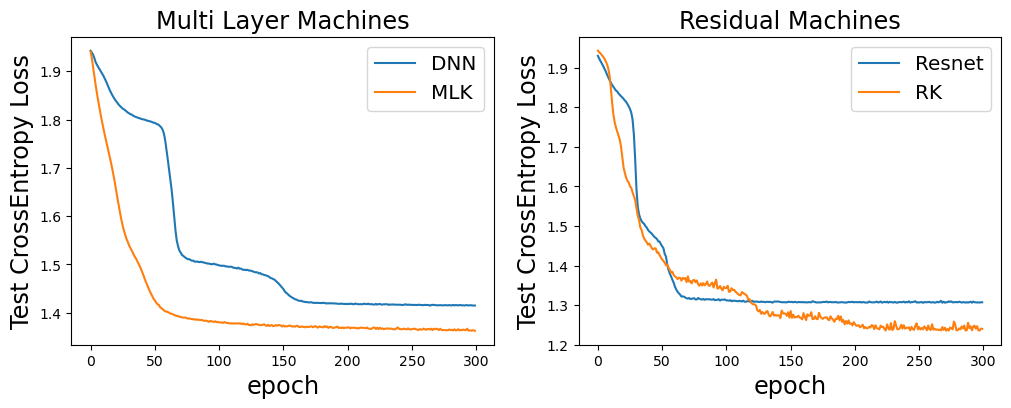

In [30]:
a=np.linspace(0,299,300)
epochset = [int(item) for item in a]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(epochset,dnn_testloss[:])
ax[0].plot(epochset,kernelnn_testloss[:])
ax[0].legend(["DNN","MLK"],fontsize="x-large")
ax[0].set_xlabel("epoch",fontsize="xx-large")
ax[0].set_ylabel("Test CrossEntropy Loss",fontsize="xx-large")
ax[0].set_title("Multi Layer Machines",fontsize="xx-large")

ax[1].plot(epochset,res_testloss[:])
ax[1].plot(epochset,reskernel_testloss[:])
ax[1].legend(["Resnet","RK"],fontsize="x-large")
ax[1].set_xlabel("epoch",fontsize="xx-large")
ax[1].set_ylabel("Test CrossEntropy Loss",fontsize="xx-large")
ax[1].set_title("Residual Machines",fontsize="xx-large")
plt.show()